# Environment Setup

We start by importing the libraries and modules needed for this analysis.

In [1]:
# Import libraries

# For reading, handling data
import os
import pandas as pd
from PIL import Image

# PyTorch modules for constructing datasets
from torch.utils.data import DataLoader, random_split

# Torchvision modules for computer vison and image handling
from torchvision import datasets, transforms

# For displaying images, plotting metrics, etc.
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# For displaying commands in each cell
from IPython.core.interactiveshell import InteractiveShell

# tqdm allows us to display a progress bar for long loops
from tqdm import tqdm 

# Display output of every command in a cell
InteractiveShell.ast_node_interactivity = 'all'

# Progress bar for pandas
tqdm.pandas()

# Data Exploration

Prior to building the model, we explore the data. The dataset consists of images of different animals stored as JPEGs, with each animal grouped into one subfolder with the animal name (in Italian!). Let's start by studying the class distribution. Rather than read each JPEG, we will just count the number of files in each folder which will speed up the process.

In [2]:
# Root path to all images and
ROOT_PATH = '/kaggle/input/animals10/raw-img/'

# Path for all outputs
OUT_PATH = '/kaggle/working/'

# Since animal names are in italian we will have to translate into English
translate = {'cane': 'Dog', 
             'cavallo': 'Horse', 
             'elefante': 'Elephant', 
             'farfalla': 'Butterfly', 
             'gallina': 'Chicken', 
             'gatto': 'Cat', 
             'mucca': 'Cow', 
             'pecora': 'Sheep', 
             'ragno': 'Spider', 
             'scoiattolo': 'Squirrel'
            }

# Walk through the root dir and get the folder and file name for each image
paths, files = zip(*[(path[0], file) for path in os.walk(ROOT_PATH) for file in path[2]])

# Create pandas dataframe to store image path data
df_files = pd.DataFrame({'path': paths, 'file': files})

# Get the English name of the animal for each folder
df_files['label'] = df_files['path'].str.split('/').str[-1].apply(lambda x: translate[x])

# Group by label and sort by the size of the group
df_files = df_files.iloc[df_files.groupby('label').transform('size').argsort(kind='mergesort')].reset_index(drop=True)

# Inspect
df_files.info()
df_files.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    26179 non-null  object
 1   file    26179 non-null  object
 2   label   26179 non-null  object
dtypes: object(3)
memory usage: 613.7+ KB


,path,file,label
0,/kaggle/input/animals10/raw-img/elefante,OIP-QeF6RwJQuXjYWQOXa4PLGwHaE6.jpeg,Elephant
1,/kaggle/input/animals10/raw-img/elefante,OIP-GIzroxEWulvjZ6Me9KFSnwHaFj.jpeg,Elephant
2,/kaggle/input/animals10/raw-img/elefante,OIP--UnQR8C6k6T8rQuJOQ87QgHaFj.jpeg,Elephant
3,/kaggle/input/animals10/raw-img/elefante,eb3cb80d2ff2023ed1584d05fb1d4e9fe777ead218ac10...,Elephant
4,/kaggle/input/animals10/raw-img/elefante,OIP-Lbhfmoj1wIbVE55UJcTWhAHaFm.jpeg,Elephant


We know the dataset contains 26179 images. Let's get a visualization of the class distribution in the dataset.

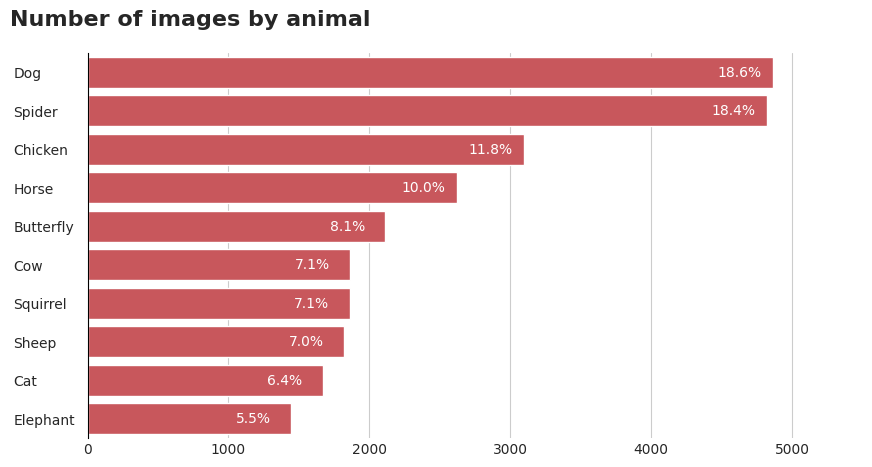

In [3]:
# Plot the file counts and percentages

# Set seaborn style
sns.set_style('whitegrid')

# Define color mapping
color_map = {'red': '#DB444B',
             'blue': '#006BA2', 
             'green': '#379A8B',
             'magenta': '#D23EBC', 
             'cyan': '#3EBCD2', 
             'yellow': '#EBB434', 
             'purple': '#9A607F',
             'olive': '#B4BA39',  
             'gold': '#D1B07C', 
             'gray': '#758D99', 
            }

label_map = {'Dog': 'red', 
             'Spider': 'blue', 
             'Chicken': 'gold', 
             'Horse': 'magenta', 
             'Butterfly': 'cyan', 
             'Cow': 'yellow', 
             'Squirrel': 'purple', 
             'Sheep': 'olive', 
             'Cat': 'green', 
             'Elephant': 'gray'
            }

# Create the figure and axes
fig, ax = plt.subplots(1, figsize=(10,5))

df_counts = df_files['label'].value_counts()
df_fracs = df_files['label'].value_counts(normalize=True)

# Plot the image counts for each animal as a horizontal bar chart (override colormap - we only need one color)
sns.barplot(x=df_counts.values, y=df_counts.index, orient='h', color=color_map['red'], zorder=2)

# Set the chart title
ax.set_title('Number of images by animal', weight='bold', fontsize=16, loc='left', x=-0.1, y=1.05)

# Annotate bars with the percentage
percent_labels = [f'{100*p:.1f}%' for p in df_fracs]
ax.bar_label(ax.containers[0], labels=percent_labels, label_type='edge', fontsize=10, color='white', padding=-40)

# Set x-axis range
ax.set_xlim([0, 5500])

# Remove x- and y-axis labels
ax.set(ylabel=None, xlabel=None)

# Set the color and padding of the tick labels
ax.tick_params(axis='x', pad=0)
ax.tick_params(axis='y', pad=50)  

# Left-align the y-axis tick labels
ax.set_yticklabels(ax.get_yticklabels(), ha='left')

# Remove y-axis grid lines
ax.yaxis.grid(False)

# Remove all but left spine, set color to black
ax.spines[['right','top', 'bottom']].set_visible(False)
ax.spines[['left']].set_color('black')

# Save the figure
plt.savefig(os.path.join(OUT_PATH,'filecounts.pdf'), bbox_inches='tight');

The classes are not uniformly distributed. Images of dogs and spiders make up 37% of the dataset in almost equal portions, while the rest of the animals each constitute between 5-10% of the dataset. To reduce training bias toward dogs and spiders, we could use a subset of the data for training with an equal number of images for each animal.

Now let's inspect the contents of the individual files, i.e., let's study the images' spatial dimensions and display a few images to confirm the class labels are consistent.

In [4]:
# Open up each image as a PIL and get the size, returning the height and width as two new columns in the df
df_files[['image_height','image_width']] = df_files.progress_apply(lambda x: Image.open(os.path.join(x.path, x.file)).size, axis=1, result_type='expand')

100%|██████████| 26179/26179 [04:09<00:00, 105.06it/s]


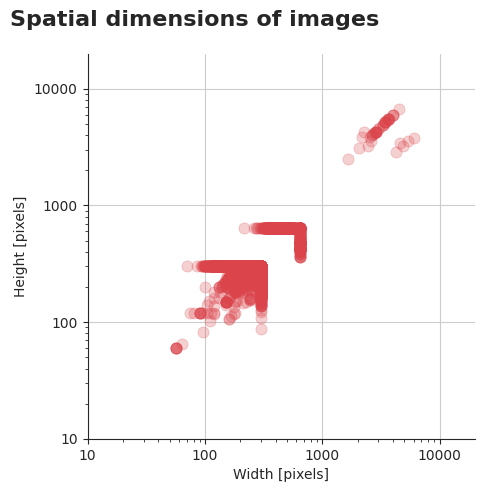

In [5]:
# Plot the different image dimensions and their frequencies

# Set seaborn style
sns.set_style('ticks')

# Create the figure and axes
fig, ax = plt.subplots(1, figsize=(5,5))

# Plot data as scatter plot with translucent markers
sns.scatterplot(data=df_files, x='image_width', y='image_height', alpha=0.25, color=color_map['red'], edgecolor=None, s=64, zorder=3) 

# Set the chart title
ax.set_title('Spatial dimensions of images', weight='bold', fontsize=16, loc='left', pad=20, x=-0.2)

# Set x- and y-axis to log scale
ax.set_yscale('log')
ax.set_xscale('log')

# Set x- and y-axis ranges
ax.set_ylim([10, 19999])
ax.set_xlim([10, 19999])

# Set x- and y-axis labels
ax.set_ylabel('Height [pixels]')
ax.set_xlabel('Width [pixels]')

# Add x- and y-axis grid lines
ax.grid()

# Remove scientific notation of ticks on x- and y-axis
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())

# Remove top and right spines
ax.spines[['right','top']].set_visible(False)

# Save the figure
plt.savefig(os.path.join(OUT_PATH,'imagedims.pdf'), bbox_inches='tight');

The image dimensions widely vary but are clustered into three groups: widths/heights between 50 and 300 pixels, which is where most of the data appear; widths/heights between 600 and 700 pixels; and a small collection of outliers with very large resolution over 1000 x 1000 pixels. We will use this figure to guide how we crop the images, since every tensor representing an image must be uniform in size among the input data when training and evaluating the model. Let's take a closer look at the distribution without the outliers.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


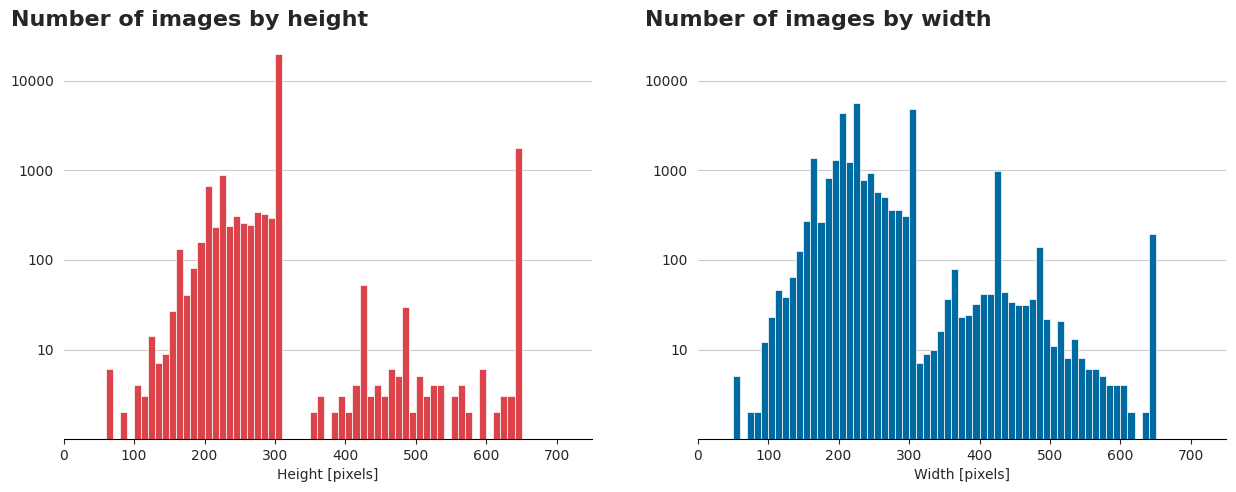

In [6]:
# Plot the different image dimensions and their frequencies

# Set seaborn style
sns.set_style('ticks')

# Create the figure and axes
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# Plot data as histograms
sns.histplot(data=df_files, x='image_height', bins=70, binrange=[0,700], color=color_map['red'], alpha=1, zorder=2, ax=ax[0]) 
sns.histplot(data=df_files, x='image_width', bins=70, binrange=[0,700], color=color_map['blue'], alpha=1, zorder=2, ax=ax[1]) 

# Set the chart title
ax[0].set_title('Number of images by height', weight='bold', fontsize=16, loc='left', pad=20, x=-0.1)
ax[1].set_title('Number of images by width', weight='bold', fontsize=16, loc='left', pad=20, x=-0.1)

# Set x- and y-axis to log scale
ax[0].set_yscale('log')
ax[1].set_yscale('log')

# Set x- and y-axis ranges
ax[0].set_ylim([1.01, 19999])
ax[1].set_ylim([1.01, 19999])
ax[0].set_xlim([0, 750])
ax[1].set_xlim([0, 750])

# Set x-axis labels and remove y-axis labels
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[0].set_xlabel('Height [pixels]')
ax[1].set_xlabel('Width [pixels]')

# Remove y-axis ticks
ax[0].tick_params(which='both', left=False)
ax[1].tick_params(which='both', left=False)

# Remove scientific notation of ticks on y-axis
ax[0].yaxis.set_major_formatter(ScalarFormatter())
ax[1].yaxis.set_major_formatter(ScalarFormatter())

# Add y-axis grid lines
ax[0].yaxis.grid()
ax[1].yaxis.grid()

# Remove all but bottom spine, set color to black
ax[0].spines[['right','left','top']].set_visible(False)
ax[0].spines['bottom'].set_color('black')

ax[1].spines[['right','left','top']].set_visible(False)
ax[1].spines['bottom'].set_color('black')

# Save the figure
plt.savefig(os.path.join(OUT_PATH,'hist_imagedims.pdf'), bbox_inches='tight');

I think it is clear from these histograms that fixing images to 300 x 300 pixels will require the fewest transformations. To ensure every image is 300 x 300 pixels, we apply two transformations:
1. Pad each side of every image with a zero-valued/black 300-pixel-wide border
2. Center-crop each padded image to a 300 x 300 pixel grid

These transformations will minimize the amount of padding for the smaller images and minimize loss of information when cropping the larger images. 

Now we'll plot a few transformed images loaded as tensors with torchvision. This is a sanity check to see that the image data are appropriate, the transforms are applied, and the class labels are correct.

In [7]:
# Define the transforms to perform on each image, for now just convert PIL to tensor
IMAGE_SIZE = 300
input_transforms = transforms.Compose([transforms.ToTensor(), # Convert image to tensor
                                       transforms.Pad(IMAGE_SIZE),
                                       #transforms.Resize(IMAGE_SIZE, antialias=True), # Resize images so there is no padding after cropping
                                       transforms.CenterCrop(IMAGE_SIZE) # Crop so input tensors have the same dimension
])

# The ImageFolder class does not read any images into memory
# It will only read and load image files when we access an element
dataset = datasets.ImageFolder(ROOT_PATH, transform=input_transforms)

# Confirm size of dataset
len(dataset)

# Get label mapping (and translate)
dataset.class_to_idx
label_to_idx = {translate[class_ita]: idx for class_ita, idx in dataset.class_to_idx.items()}
idx_to_label = {idx: translate[class_ita] for class_ita, idx in dataset.class_to_idx.items()}

# Inspect one image and get the shape
image, class_idx = dataset[0]
image.shape

26179

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

torch.Size([3, 300, 300])

In [8]:
# Split dataset into training and testing (dataset size = 26179)
train_dataset, test_dataset = random_split(dataset, [21179, 5000]) # roughly 80/20 split

# Set the batch size
BATCH_SIZE = 16

# Create and fill dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

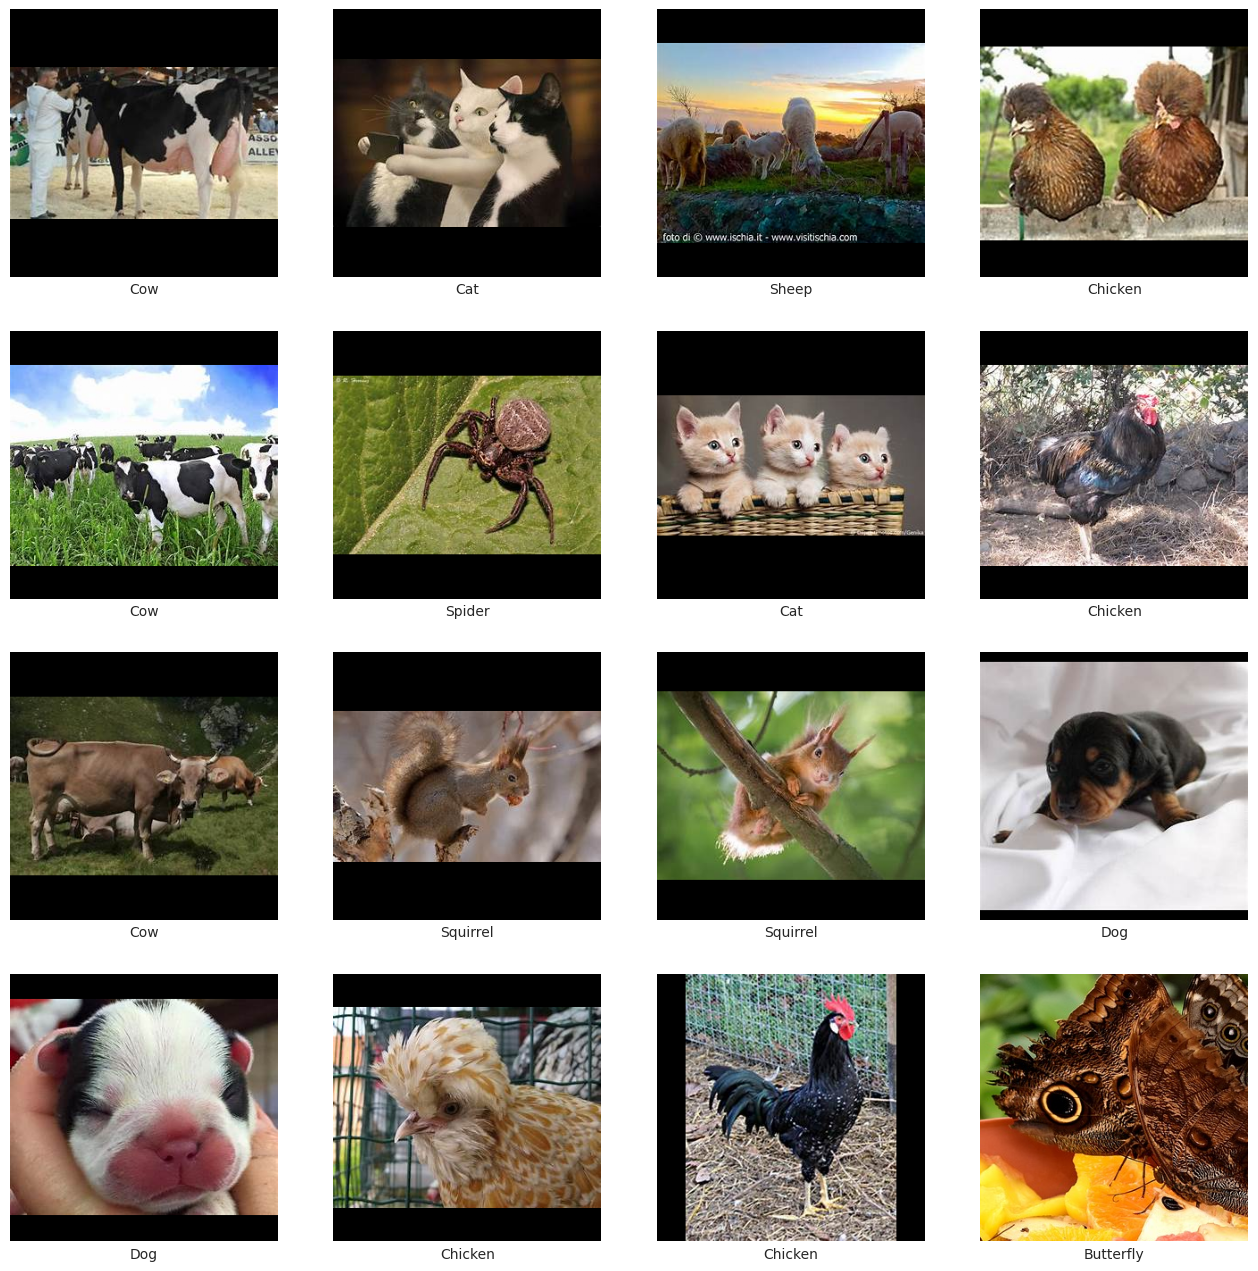

In [9]:
# Inspect the data to validate transformations, labels, etc.,

# Grab the first batch of data
features, labels = next(iter(train_dataloader))

# Plot the tensor with labels
sns.set_style('white')

# Create 4x4 subplot
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16))

# Plot images in loop
for row in range(4):
    for col in range(4):
        idx = 4*row+col
        
        # Tensors are of dimension (channel, width, height) but to plot we want (width, height, channel), so permute the dimensions
        ax[row, col].imshow(features[idx].permute(1, 2, 0))
        
        # Add class labels (in English) as x-axis labels
        ax[row, col].set_xlabel(idx_to_label[labels[idx].item()])
        
        # Remove tick labels
        ax[row, col].tick_params(which='both', axis='both', labelleft=False, labelbottom=False)
        
        # Remove spines
        ax[row, col].spines[['right','left','top', 'bottom']].set_visible(False)
        
# Save the figure
plt.savefig(os.path.join(OUT_PATH,'image_label_sample.pdf'), bbox_inches='tight');

By inspection, we can confirm the labels appropriately match the animal depicted in the corresponding image. 